# Master File

# Tools & Libraries

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [2]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import boxplot_histogram

In [3]:
from pa_lib.data import desc_col

# Load Dataset (Data Preparation)

In [4]:
from vkprog_data_prep import bd_train_scoring

In [5]:
%%time

(training_all, scoring_all, feature_colnames_bd, feature_colnames_dates) = bd_train_scoring(
    day=23,
    month=9,
    year_score=2019,
    year_train=2018,
    year_span=4,
    scale_features=True)

2019-10-02 10:03:00 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
2019-10-02 10:03:00 [INFO] Finished loading binary file in 0.35s (0.81s CPU)
2019-10-02 10:03:01 [INFO] Period: KW_2
2019-10-02 10:03:01 [INFO] Calculate Reservation...
2019-10-02 10:03:01 [INFO] Calculate Aushang...
2019-10-02 10:03:02 [INFO] Merge Results...
2019-10-02 10:03:02 [INFO] aggregate_bookings: Done.
2019-10-02 10:03:02 [INFO] current_yyyykw: 201939
2019-10-02 10:03:02 [INFO] training_yyyykw:201839
2019-10-02 10:03:02 [INFO] Computing: Pivot Table
2019-10-02 10:03:03 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
2019-10-02 10:03:03 [INFO] Computing: Yearly total sums
2019-10-02 10:03:03 [INFO] Merging: Left-Join to Container dataframe
2019-10-02 10:03:03 [INFO] Merging: Left-Join to Container dataframe
2019-10-02 10:03:03 [INFO] Merging: Left-Join to Container dataframe
2019-10-02 10:03:03 [INFO] Merging: Left-Join to Container dataframe
2019-10-02 10:03:03 [INFO] Final merge
2

Wall time: 9.98 s


In [9]:
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())


training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,...,Target_Sum_Aus_RY_0_KW_39,Target_Sum_Res_RY_0_KW_39,Netto_Sum_Aus_RY_0,Netto_Sum_Res_RY_0,Netto_Sum_Aus_RY_1,Netto_Sum_Res_RY_1,Netto_Sum_Aus_RY_2,Netto_Sum_Res_RY_2,Netto_Sum_Aus_RY_3,Netto_Sum_Res_RY_3
count,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,...,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000,18003.000000
mean,485050.424096,0.391571,0.135616,0.292941,0.032810,0.018464,0.028818,0.017104,0.030254,0.017269,...,0.023409,0.023380,0.266975,0.259632,0.267759,0.262583,0.279641,0.271942,0.279279,0.278762
std,186662.811738,0.289579,0.152127,0.307696,0.143494,0.107028,0.129294,0.102330,0.135663,0.104390,...,0.120170,0.118754,0.284604,0.284913,0.276718,0.281474,0.280691,0.279344,0.291397,0.290046
min,100034.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,472931.500000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,574381.000000,0.272727,0.125000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.371506,0.317957,0.000000,0.000000
75%,614320.500000,0.727273,0.250000,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.540298,0.540294,0.526841,0.533050,0.537117,0.532386,0.553616,0.551227
max,651482.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,...,Target_Sum_Aus_RY_0_KW_39,Target_Sum_Res_RY_0_KW_39,Netto_Sum_Aus_RY_0,Netto_Sum_Res_RY_0,Netto_Sum_Aus_RY_1,Netto_Sum_Res_RY_1,Netto_Sum_Aus_RY_2,Netto_Sum_Res_RY_2,Netto_Sum_Aus_RY_3,Netto_Sum_Res_RY_3
count,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,...,18043.000000,0.0,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000,18043.000000
mean,498008.869201,0.385122,0.218744,0.320704,0.029308,0.016562,0.029451,0.015312,0.028634,0.016268,...,0.028614,NaN,0.256040,0.255911,0.253989,0.249478,0.258853,0.252107,0.267225,0.261113
std,187832.419957,0.294898,0.248461,0.340630,0.133487,0.102479,0.134181,0.097394,0.131965,0.098747,...,0.131622,NaN,0.275159,0.277429,0.270549,0.269993,0.267861,0.270431,0.269407,0.269030
min,100034.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,478437.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,586672.000000,0.333333,0.200000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351798,0.263241
75%,627169.000000,0.666667,0.400000,0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,0.523333,0.525845,0.514470,0.512575,0.510348,0.512310,0.515734,0.513195
max,659388.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#desc_col(training_all)

Target_Res_flg == False


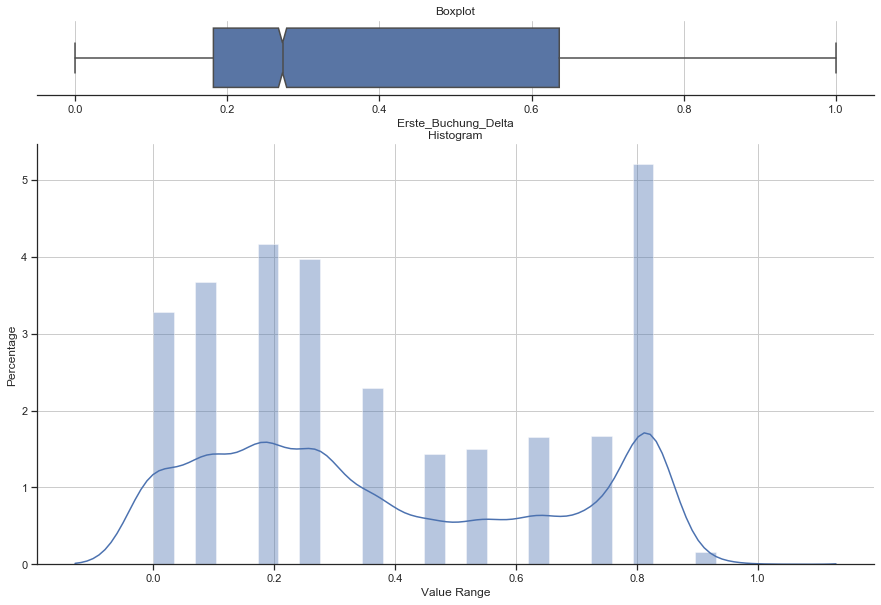

Target_Res_flg == True


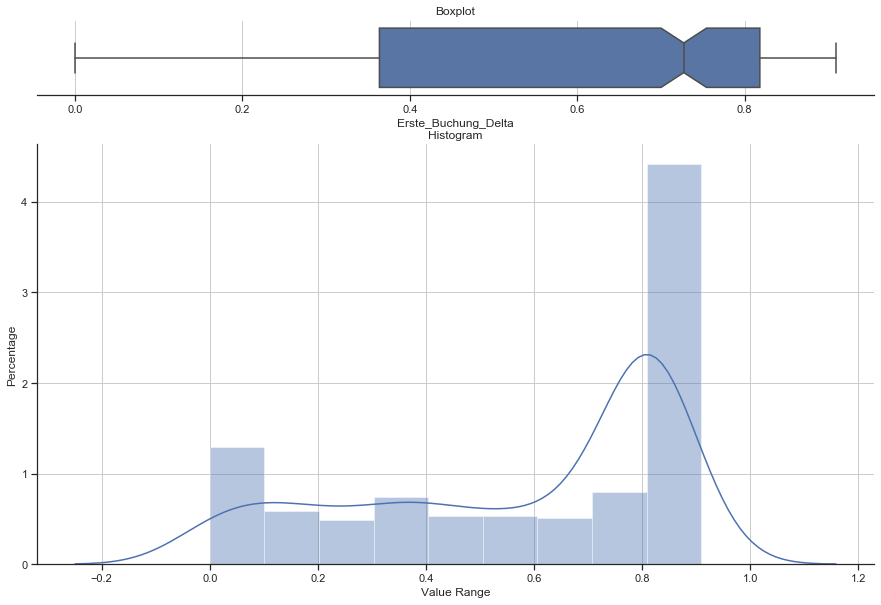

Target_Res_flg == False


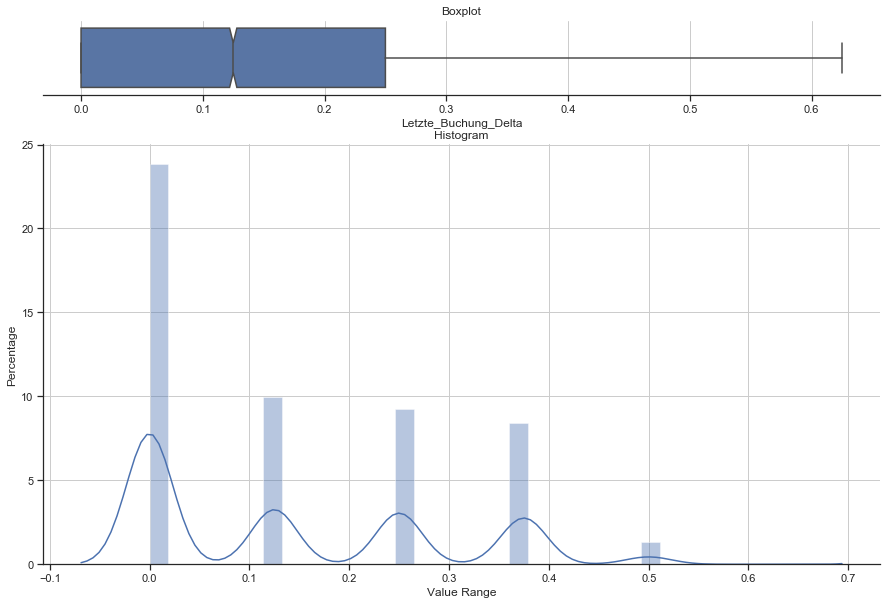

Target_Res_flg == True


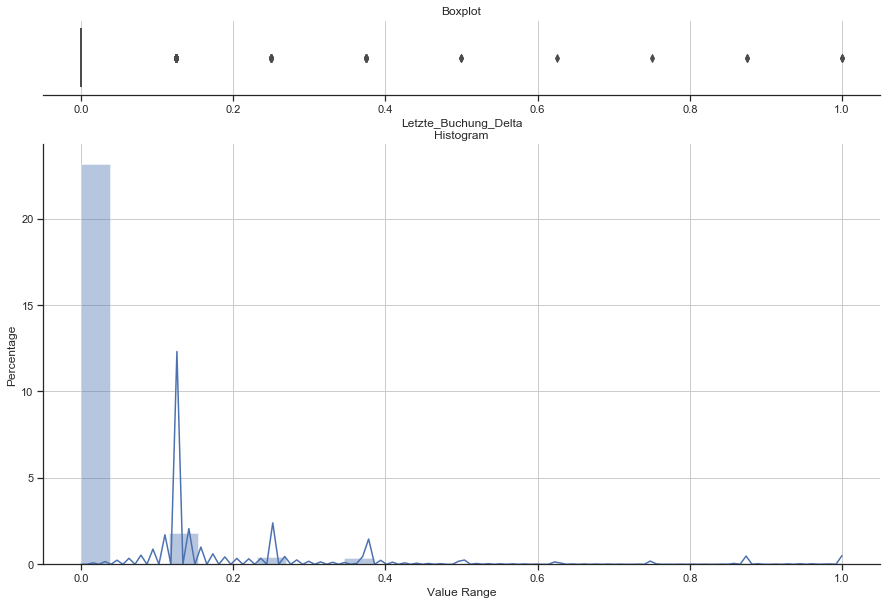

Target_Res_flg == False


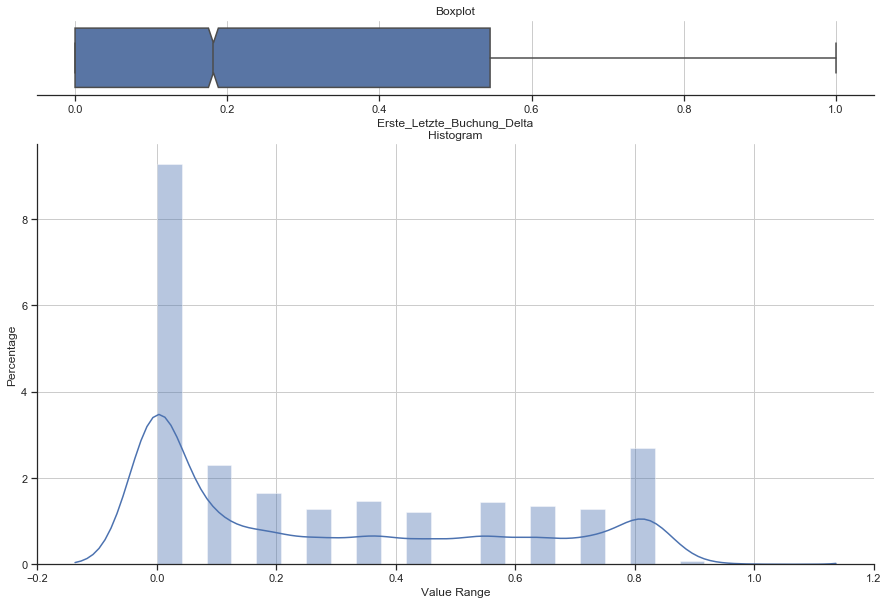

Target_Res_flg == True


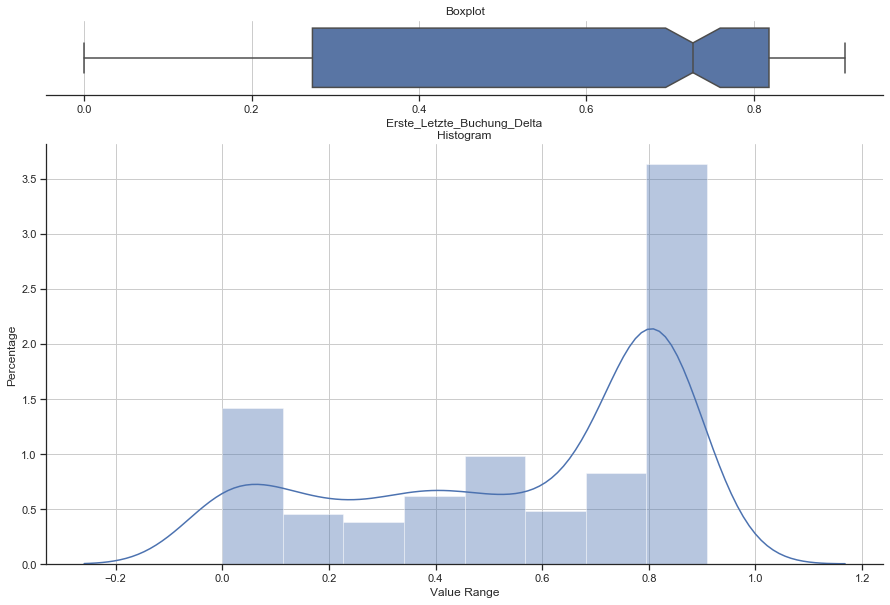

In [11]:
temp_df = training_all
print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Buchung_Delta"])

print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Letzte_Buchung_Delta"])


print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Letzte_Buchung_Delta"])

# Modeling

## Define Columns: Features versus Targets

In [12]:
from itertools import compress
features = feature_colnames_bd + feature_colnames_dates
#feature_columns = list(compress(features,["Target" not in s for s in features]))

feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

#target_columns  = list(compress(training_all.columns,["Target" in s for s in training_all.columns]))

In [13]:
len(feature_columns)
print(target_columns)

214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_39
217    Target_Sum_Res_RY_0_KW_39
dtype: object


In [14]:
#["Target" not in s for s in features]
#features
#feature_columns

## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [15]:
df_features = training_all.loc[:,feature_columns].to_numpy()
df_target   = training_all.loc[:, "Target_Res_flg"].to_numpy()

df_scoring_features = scoring_all.loc[:,feature_columns].to_numpy()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)

In [17]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("\ndf_scoring_features", df_scoring_features.shape)

Shape:
X_train: (13502, 219)
y_train: (13502,)
X_test: (4501, 219)
y_test: (4501,)

df_scoring_features (18043, 219)


In [23]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))


y_train:
0
False    12994
True       508
Name: 0, dtype: int64
DescribeResult(nobs=13502, minmax=(False, True), mean=0.037624055695452525, variance=0.0362111680399015, skewness=4.859818425043071, kurtosis=21.617835124388115)

y_test:
0
False    4318
True      183
Name: 0, dtype: int64
DescribeResult(nobs=4501, minmax=(False, True), mean=0.040657631637413906, variance=0.03901325631341183, skewness=4.651667351296826, kurtosis=19.638009147120837)


## Balance Training Dataset

In [24]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [25]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    12994
True     12994
Name: 0, dtype: int64
DescribeResult(nobs=25988, minmax=(False, True), mean=0.5, variance=0.25000962019471273, skewness=0.0, kurtosis=-2.0)


## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [26]:
#from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif
from itertools import compress

In [27]:
%%time
#Wall time: 38.1 s

# use f_classif (the default) and SelectPercentile to select 50% of features
"""
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=100)
"""
select = SelectKBest(score_func=mutual_info_classif,
            k=100 # How many features? (currently 219 is max)
            )
select.fit(X_train_balanced, y_train_balanced)

mask = select.get_support() # boolean array.

Wall time: 36.1 s


In [28]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (25988, 219)
X_train_balanced[:,mask].shape: (25988, 100)


In [29]:
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [31]:
print("X_scoring:",X_scoring.shape)

X_scoring: (18043, 100)


## Model Training

### Logistic Regression (base model)

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=1000 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C1000.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C1000.score(X_test, y_test)))

Training set score: 0.846
Test set score: 0.914
Wall time: 529 ms


In [34]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=0.001 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C0001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C0001.score(X_test, y_test)))

Training set score: 0.804
Test set score: 0.912
Wall time: 329 ms


#### Plot Coefficients

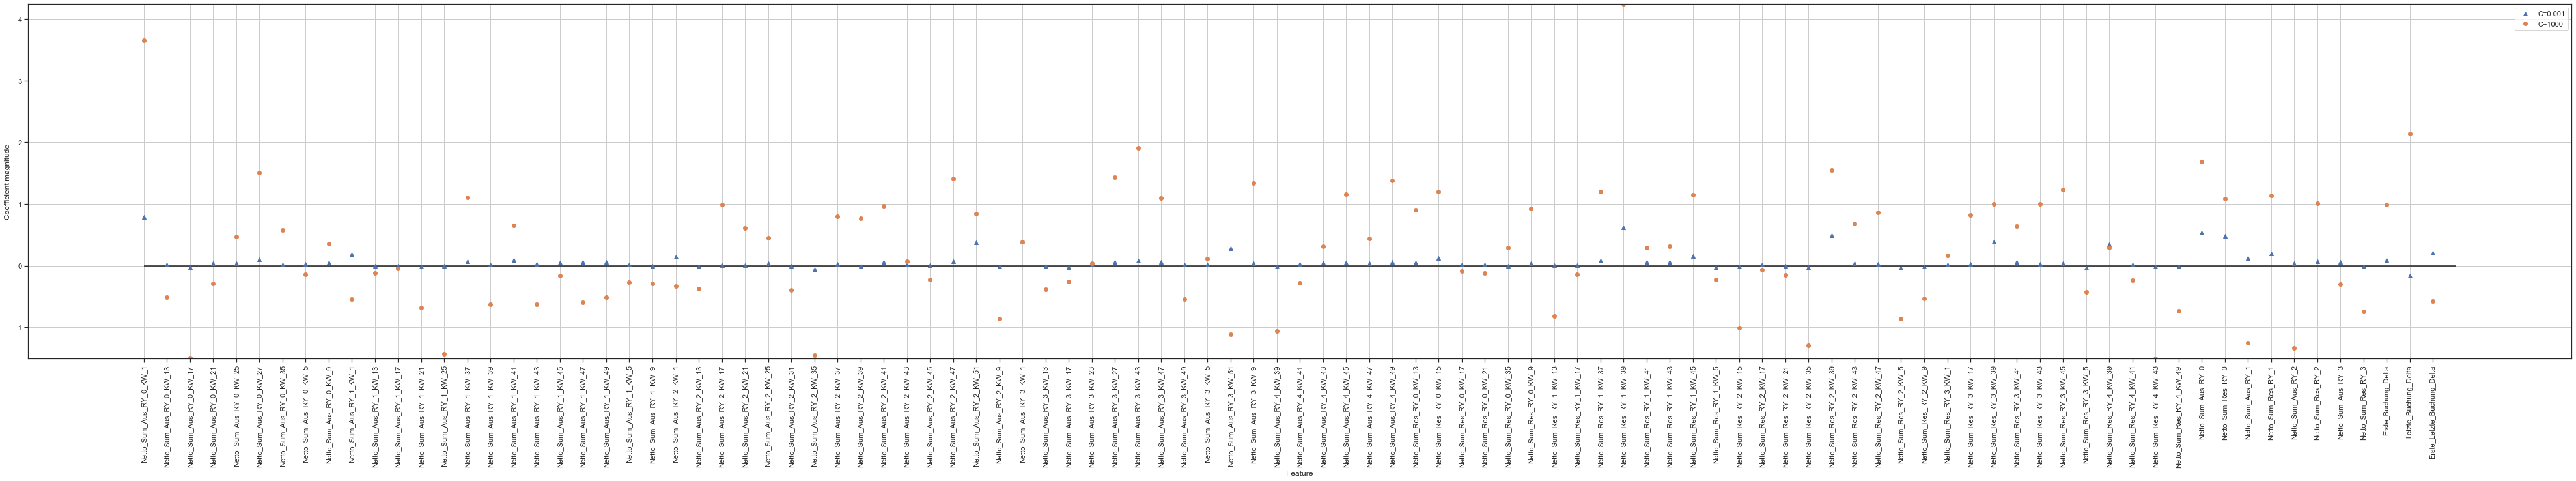

In [35]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_C0001.coef_.T, '^', label="C=0.001")
plt.plot(logreg_C1000.coef_.T,    'o', label="C=1000")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

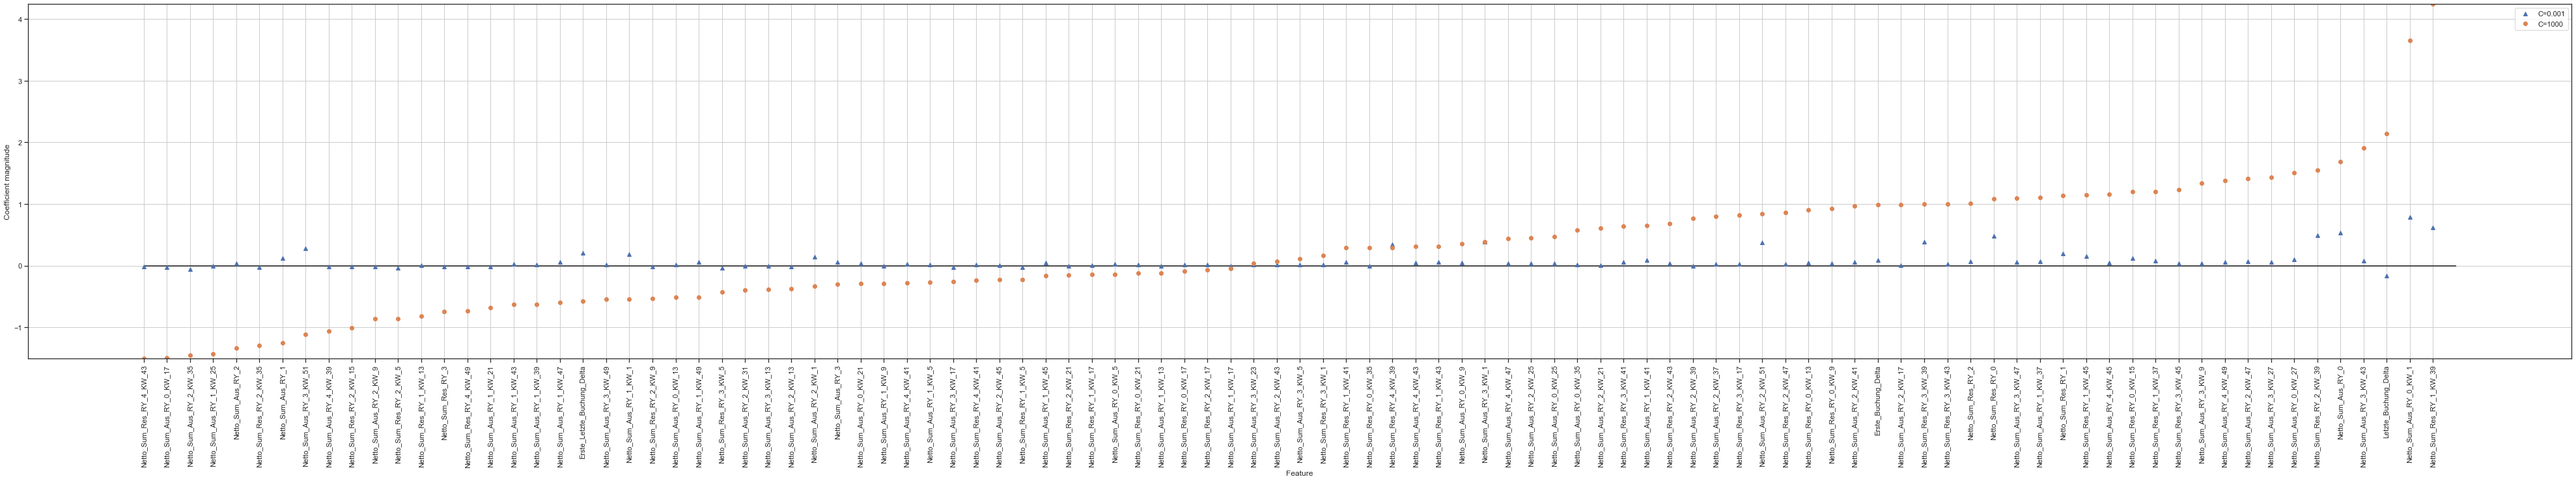

In [36]:
test_df = pd.DataFrame(data={'feature': pd.Series(feature_columns), 
                             'C1000': list(logreg_C1000.coef_.T),
                            'C0001': list(logreg_C0001.coef_.T)})
test_df = test_df.sort_values(by=['C1000']).reset_index()

# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(test_df.loc[:,'C0001'], '^', label="C=0.001")
plt.plot(test_df.loc[:,'C1000'], 'o', label="C=1000")
plt.xticks(range(len(feature_columns)), test_df.loc[:,'feature'], rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Model Training: Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
%%time 
# Wall time: 1min 50s
forest_01 = RandomForestClassifier(n_estimators=10000,
                                max_depth=15,
                                random_state=42,
                                n_jobs=-1)
forest_01.fit(X_train_balanced, y_train_balanced)

# %% Validate Accuracy
print("Accuracy on training set: {:.3f}".format(forest_01.score(X_train_balanced,y_train_balanced)))
print("Accuracy on test set: {:.3f}".format(forest_01.score(X_test,     y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.968
Wall time: 1min 29s


In [39]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

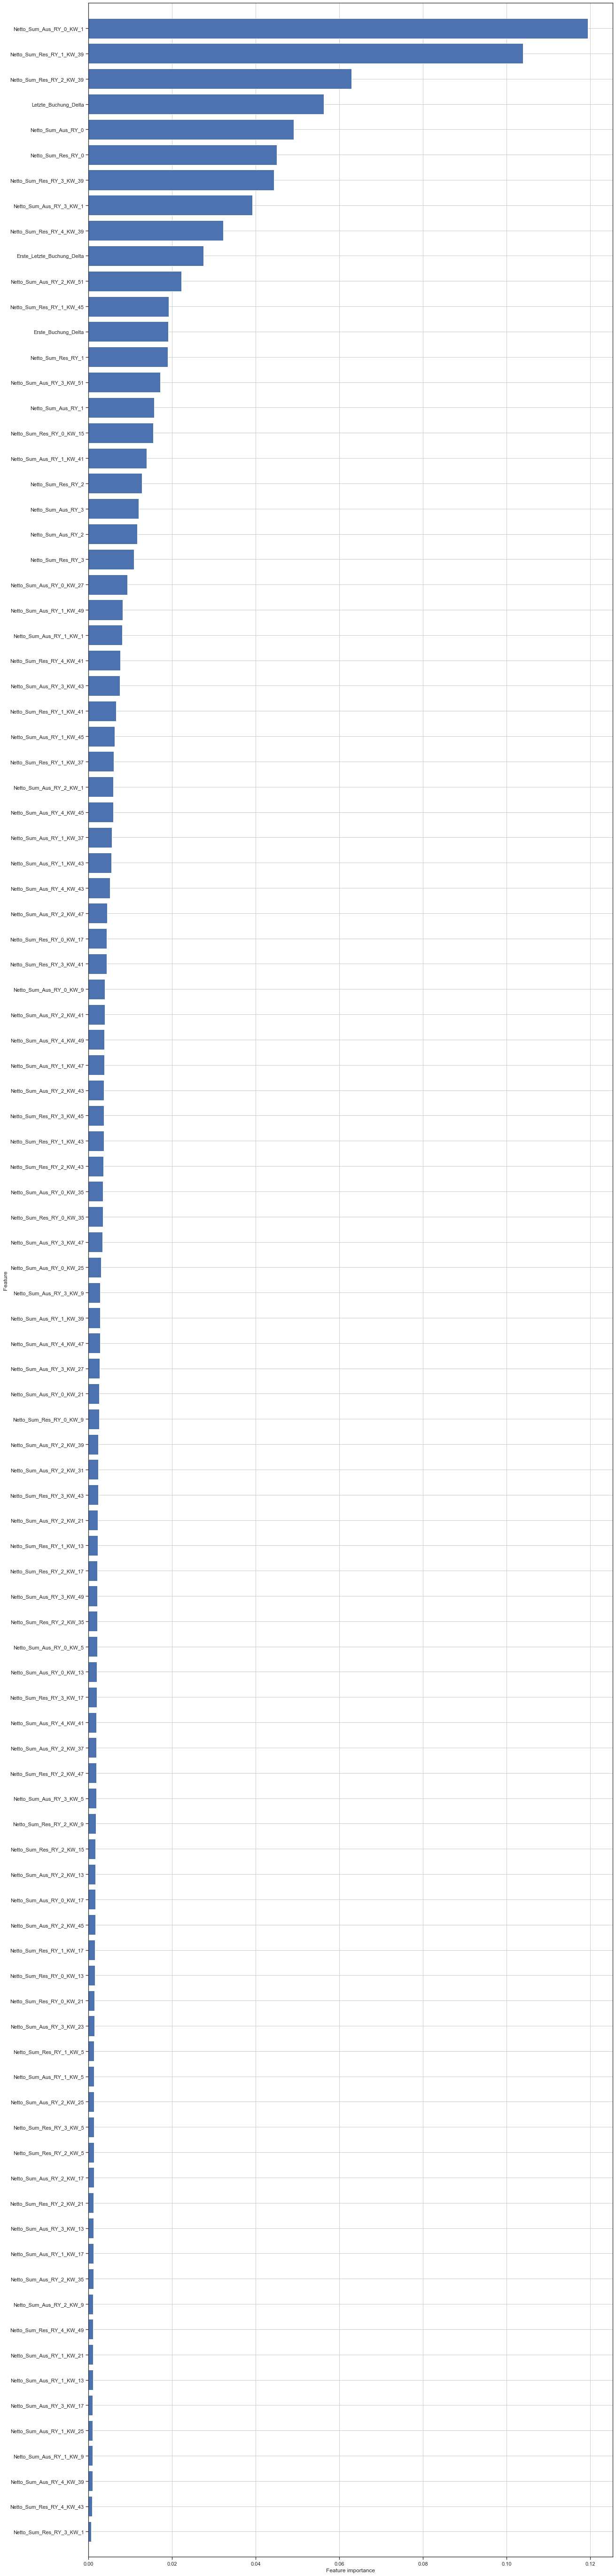

In [40]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01          = forest_01.predict(X_test)
    pred_logreg_C0001       = logreg_C0001.predict(X_test)
    pred_logreg_C1000       = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001       = confusion_matrix(y_test, pred_logreg_C0001)
    df_confusion_logreg_C0001    = pd.DataFrame(confusion_logreg_C0001, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_logreg_C1000       = confusion_matrix(y_test, pred_logreg_C1000)
    df_confusion_logreg_C1000    = pd.DataFrame(confusion_logreg_C1000, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_forest_01          = confusion_matrix(y_test, pred_forest_01)
    df_confusion_forest_01       = pd.DataFrame(confusion_forest_01, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [43]:
confusion_matrices(X_train_balanced,y_train_balanced)

Test set balance:
True     12994
False    12994
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,12939,55
Fact 1,356,12638



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,11821,1173
Fact 1,3915,9079



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,11789,1205
Fact 1,2793,10201


In [44]:
confusion_matrices(X_train,y_train)

Test set balance:
False    12994
True       508
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,12939,55
Fact 1,76,432



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,11821,1173
Fact 1,136,372



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,11789,1205
Fact 1,112,396


In [45]:
confusion_matrices(X_test,y_test)

Test set balance:
False    4318
True      183
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,4264,54
Fact 1,90,93



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,3973,345
Fact 1,50,133



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,3980,338
Fact 1,48,135


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [46]:
from sklearn.metrics import classification_report

In [47]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(classification_report(y_test,
                            pred_logreg_C0001,
                            target_names=["not booking = 0", "booking = 1"]))

print("Logistic Regression C=1000:")
print(classification_report(y_test,
                            pred_logreg_C1000,
                            target_names=["not booking = 0", "booking = 1"]))

print("Random Forest:")
print(classification_report(y_test,
                            pred_forest_01,
                            target_names=["not booking = 0", "booking = 1"]))



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.92      0.95      4318
    booking = 1       0.28      0.73      0.40       183

       accuracy                           0.91      4501
      macro avg       0.63      0.82      0.68      4501
   weighted avg       0.96      0.91      0.93      4501

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.92      0.95      4318
    booking = 1       0.29      0.74      0.41       183

       accuracy                           0.91      4501
      macro avg       0.64      0.83      0.68      4501
   weighted avg       0.96      0.91      0.93      4501

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.98      0.99      0.98      4318
    booking = 1       0.63      0.51      0.56       183

       accuracy                           0.97      4501
      

## Precision-Recall Curve

In [48]:
logreg_C1000.predict_proba(X_test)[:,1]

array([0.13757015, 0.24732727, 0.68512578, ..., 0.06958645, 0.19226421,
       0.24940974])

In [215]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01, recall_forest_01, thresholds_forest_01, precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001,precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    # LogReg C=0.001
    precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001 = precision_recall_curve(
        y_test, 
        logreg_C0001.predict_proba(X_test)[:,1])
    
    # LogReg C=1000
    precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 = precision_recall_curve(
        y_test, 
        logreg_C1000.predict_proba(X_test)[:,1])
    
    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest_01, recall_forest_01, thresholds_forest_01 = precision_recall_curve(
        y_test,
        forest_01.predict_proba(X_test)[:, 1])
    
    

In [220]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name,dot):
        optimum_idx = pd.Series.idxmin(np.power(1-pd.Series(precision_forest_01),2)+np.power(1-pd.Series(recall_forest_01),2))
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize=10,
                     label=f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle="none",
                     c='k',
                     mew=2)

    optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name="forest_01",dot='o')
    optimum_point(precision_logreg_C0001,recall_logreg_C0001,thresholds_logreg_C0001,name="logreg_C0001",dot='x')
    optimum_point(precision_logreg_C1000,recall_logreg_C1000,thresholds_logreg_C1000,name="logreg_C1000",dot='+')

    plt.plot(precision_logreg_C0001, recall_logreg_C0001, label="Logistic Regression, C=0.001")
    plt.plot(precision_logreg_C1000, recall_logreg_C1000, label="Logistic Regression, C=1000")
    plt.plot(precision_forest_01, recall_forest_01, label="Random Forest")

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


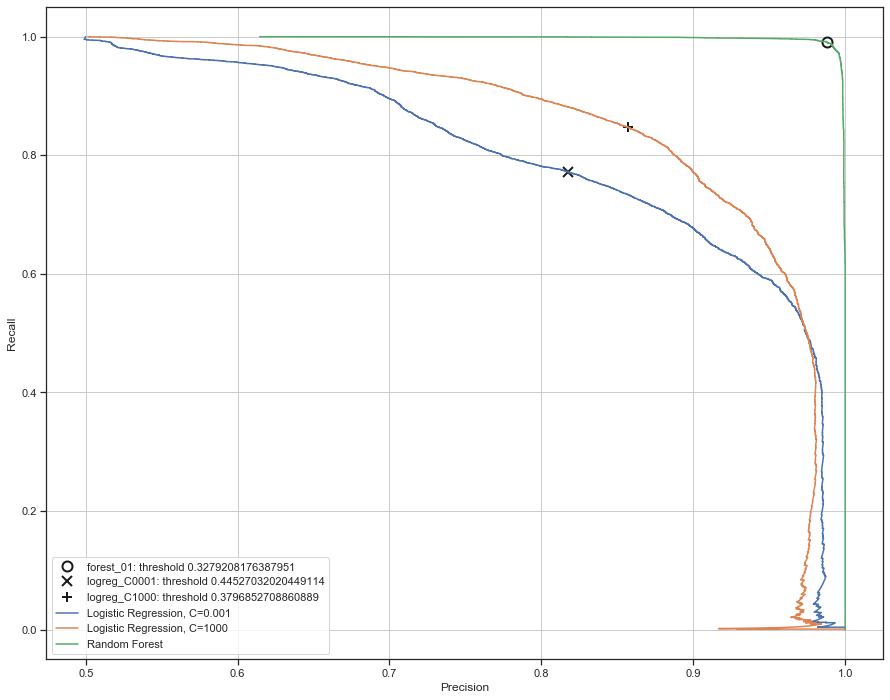

In [221]:
prec_rec_curve(X_train_balanced,y_train_balanced)

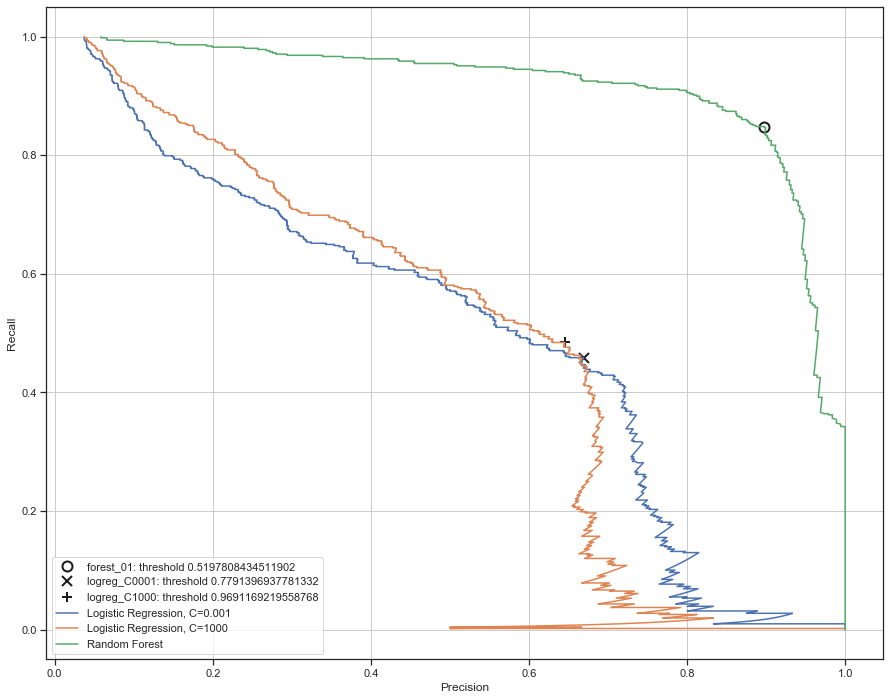

In [222]:
prec_rec_curve(X_train,y_train)

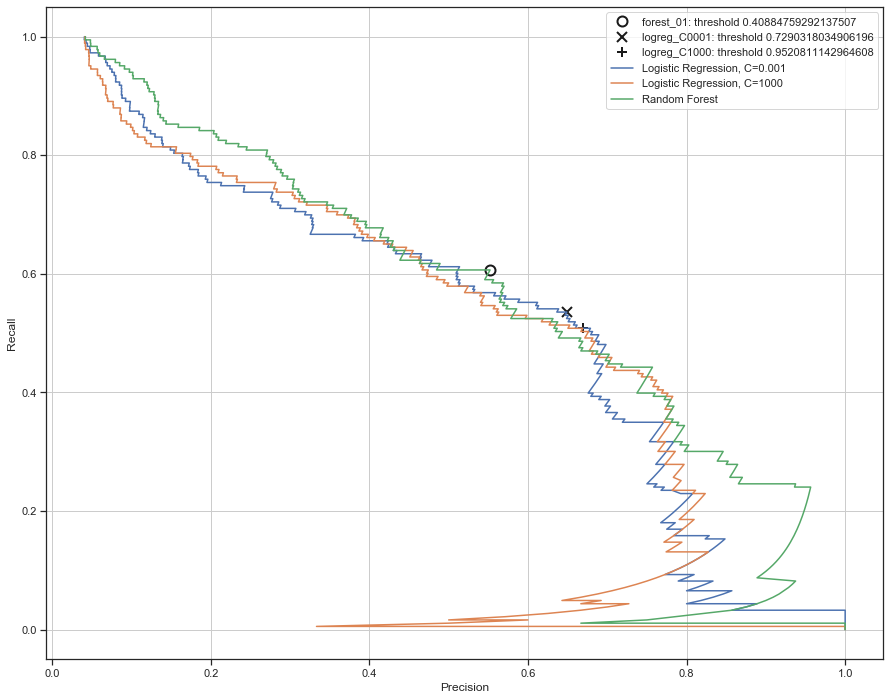

In [223]:
prec_rec_curve(X_test,y_test)

In [52]:
#boxplot_histogram(thresholds_logreg_C0001)

In [53]:
%%time
#Wall time: 19.7 s

from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_logreg_C0001 = average_precision_score(y_test,
                                               logreg_C0001.predict_proba(X_test)[:, 1])

avg_precision_logreg_C1000 = average_precision_score(y_test,
                                               logreg_C1000.predict_proba(X_test)[:, 1])

avg_precision_forest_01 = average_precision_score(y_test,
                                               forest_01.predict_proba(X_test)[:, 1])


print("Average Precision of LogReg C=0.001: {:.3f}".format(avg_precision_logreg_C0001))
print("Average Precision of LogReg C=1000:  {:.3f}".format(avg_precision_logreg_C1000))
print("Average Precision of forest_01:      {:.3f}".format(avg_precision_forest_01))

Average Precision of LogReg C=0.001: 0.532
Average Precision of LogReg C=1000:  0.520
Average Precision of forest_01:      0.583
Wall time: 12.8 s


## Receiver Operating Characteristics (ROC) and AUC


In [195]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001, fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000, fpr_forest_01, tpr_forest_01, thresholds_forest_01
    fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001 = roc_curve(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000 = roc_curve(y_test, logreg_C1000.predict_proba(X_test)[:, 1])
    fpr_forest_01, tpr_forest_01, thresholds_forest_01 = roc_curve(y_test, forest_01.predict_proba(X_test)[:, 1])

    def threshold_dot_50perc(fpr_forest_01,tpr_forest_01,thresholds_forest_01,name,dot):

        close_default_index_forest_01 = pd.Series.idxmin(np.power(1-pd.Series(tpr_forest_01),2)+np.power(pd.Series(fpr_forest_01),2))
        return plt.plot(fpr_forest_01[close_default_index_forest_01], tpr_forest_01[close_default_index_forest_01],
                 dot,
                 markersize=10,
                 label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
                 fillstyle="none",
                 c='k',
                 mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,fpr_forest_01, linestyle='dotted', label="base line")

    plt.plot(fpr_logreg_C0001, tpr_logreg_C0001, label="logreg_C0001")
    plt.plot(fpr_logreg_C1000, tpr_logreg_C1000, label="logreg_C1000")
    plt.plot(fpr_forest_01,    tpr_forest_01,    label="forest_01")


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,tpr_forest_01,     thresholds_forest_01,'forest_01',dot='^')
    threshold_dot_50perc(fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001,'logreg_C0001',dot='x')
    threshold_dot_50perc(fpr_logreg_C1000,tpr_logreg_C1000,thresholds_logreg_C1000,'logreg_C1000',dot='+')

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [196]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc    = roc_auc_score(y_test,    forest_01.predict_proba(X_test)[:, 1])
    logreg_C0001_auc = roc_auc_score(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    logreg_C1000_auc = roc_auc_score(y_test, logreg_C1000.predict_proba(X_test)[:, 1])


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


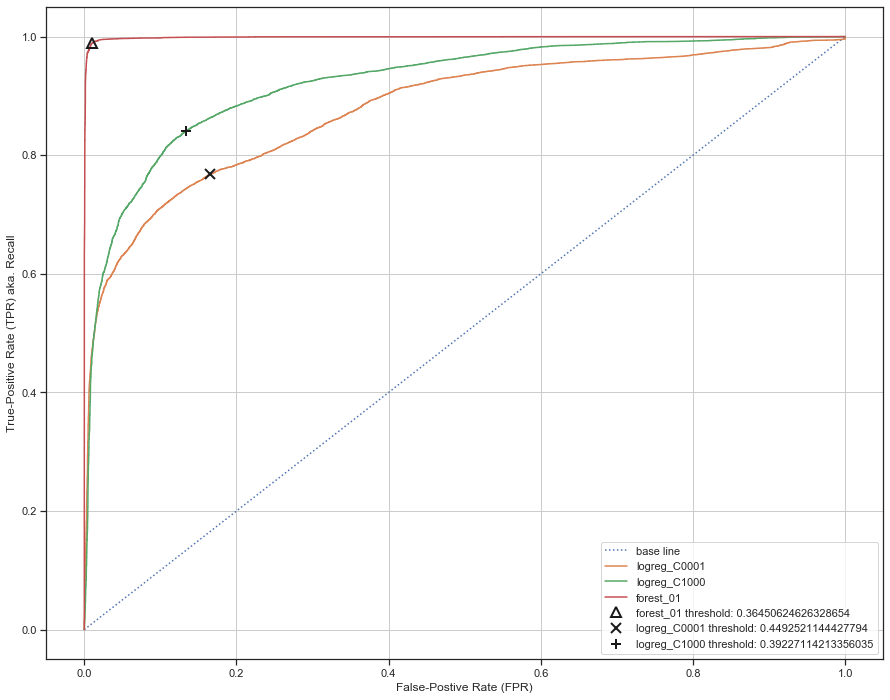

AUC for forest_01:    0.999
AUC for logreg_C0001: 0.879
AUC for logreg_C1000: 0.924
Wall time: 27.6 s


In [197]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,y_train_balanced)
roc_auc(X_train_balanced,y_train_balanced)

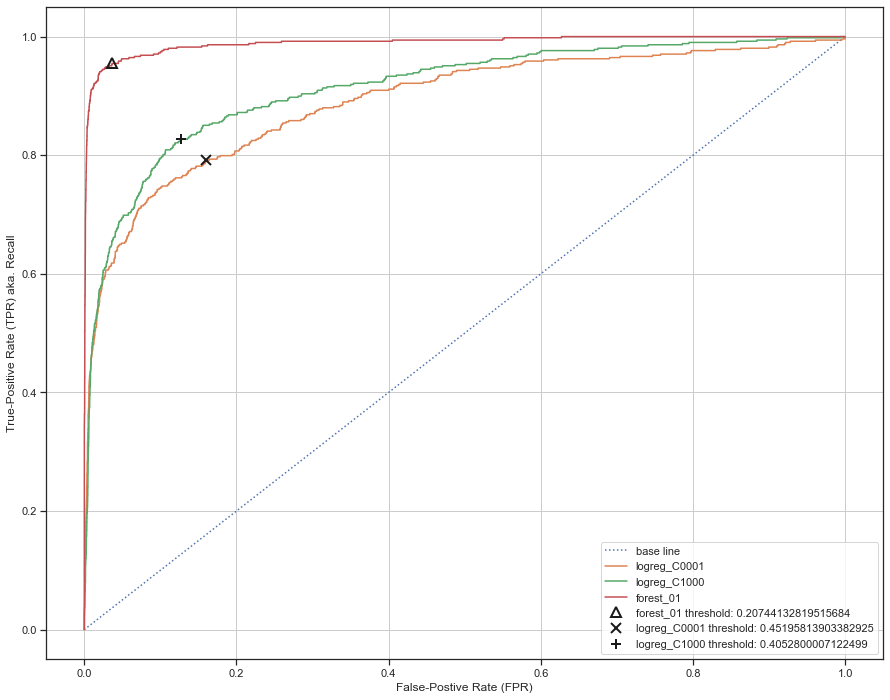

AUC for forest_01:    0.990
AUC for logreg_C0001: 0.891
AUC for logreg_C1000: 0.915
Wall time: 26 s


In [198]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,y_train)
roc_auc(X_train,y_train)

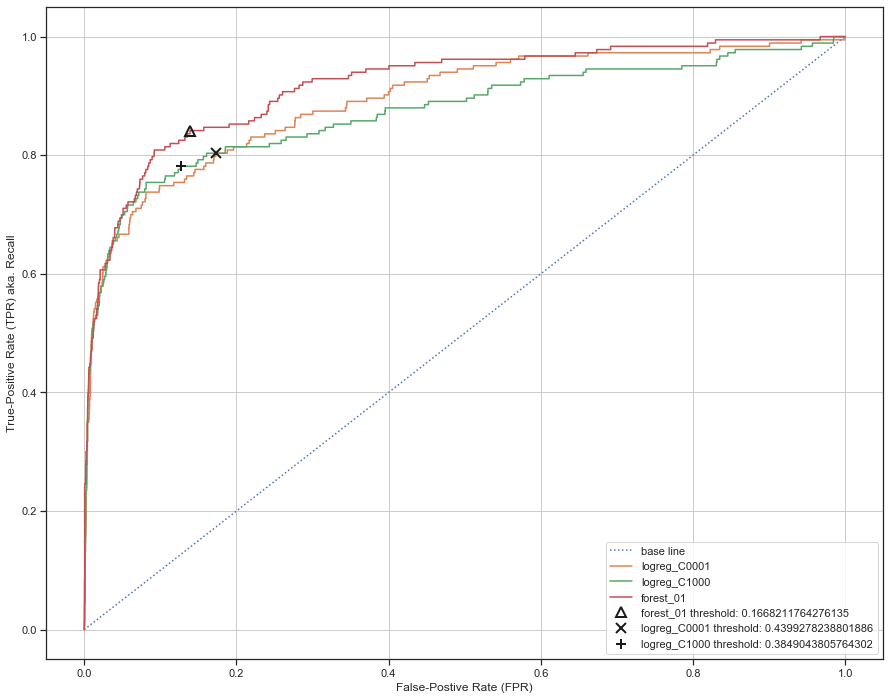

AUC for forest_01:    0.918
AUC for logreg_C0001: 0.894
AUC for logreg_C1000: 0.875
Wall time: 22.5 s


In [199]:
%%time
roc_curve_graph(X_test,y_test)
roc_auc(X_test,y_test)

## Recursive feature elimination with cross-validation

## Shapley values

https://medium.com/@santiagof/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624

In [ ]:
import shap

In [ ]:
%%time
#Wall time: OVER9000!!!
#shap_values = shap.TreeExplainer(forest_01).shap_values(X_train_balanced)

In [ ]:
#shap.summary_plot(shap_values, X_train_balanced, plot_type="bar")

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [102]:
scoring_prob     = forest_01.predict_proba(X_scoring)
scoring_prob_df  = pd.DataFrame(scoring_prob, columns=["Prob_0","Prob_1"])
scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [106]:
scoring_all_prob.head()

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,...,Netto_Sum_Aus_RY_0,Netto_Sum_Res_RY_0,Netto_Sum_Aus_RY_1,Netto_Sum_Res_RY_1,Netto_Sum_Aus_RY_2,Netto_Sum_Res_RY_2,Netto_Sum_Aus_RY_3,Netto_Sum_Res_RY_3,Prob_0,Prob_1
8776,582981,2013-10-23,2018-10-01,0.416667,0.0,0.454545,0.544927,0.0,0.0,0.0,...,0.457123,0.459317,0.451051,0.450512,0.445781,0.450279,0.446593,0.445947,0.005422,0.994578
3498,278270,2013-11-01,2019-01-23,0.416667,0.0,0.454545,0.571738,0.0,0.0,0.0,...,0.518415,0.520904,0.473244,0.472678,0.467714,0.472433,0.468566,0.467888,0.006128,0.993872
8781,583004,2013-10-24,2019-02-01,0.416667,0.0,0.454545,0.544927,0.0,0.0,0.0,...,0.503048,0.505463,0.496367,0.495773,0.490567,0.495516,0.491460,0.490749,0.006253,0.993747
8546,578797,2013-10-07,2018-10-01,0.416667,0.0,0.454545,0.643583,0.0,0.0,0.0,...,0.539883,0.542475,0.532712,0.532075,0.526488,0.531800,0.527447,0.526683,0.006447,0.993553
8772,582952,2013-10-23,2018-10-01,0.416667,0.0,0.454545,0.623854,0.0,0.0,0.0,...,0.523333,0.525845,0.516382,0.515764,0.510348,0.515497,0.511277,0.510538,0.006969,0.993031


## Cutoff

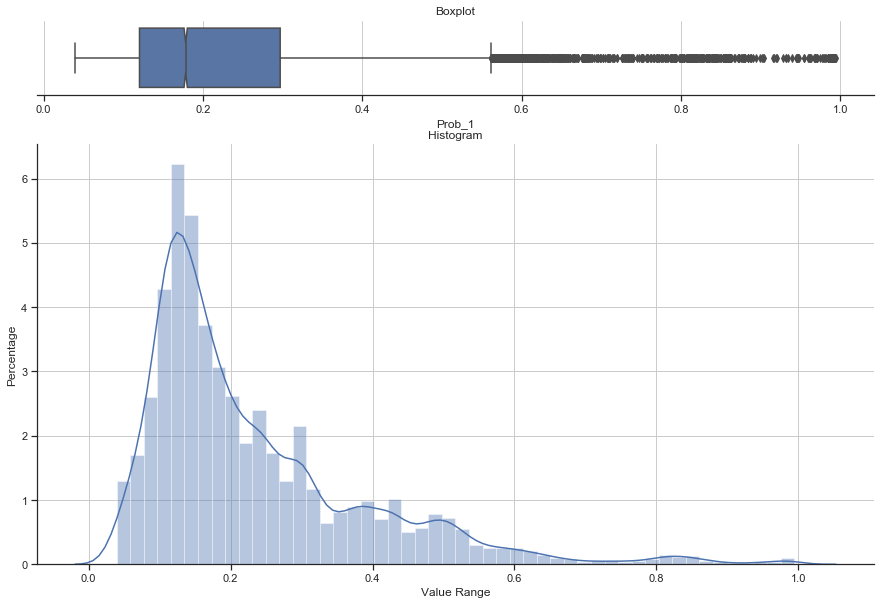

In [107]:
boxplot_histogram(scoring_all_prob.loc[:,"Prob_1"])

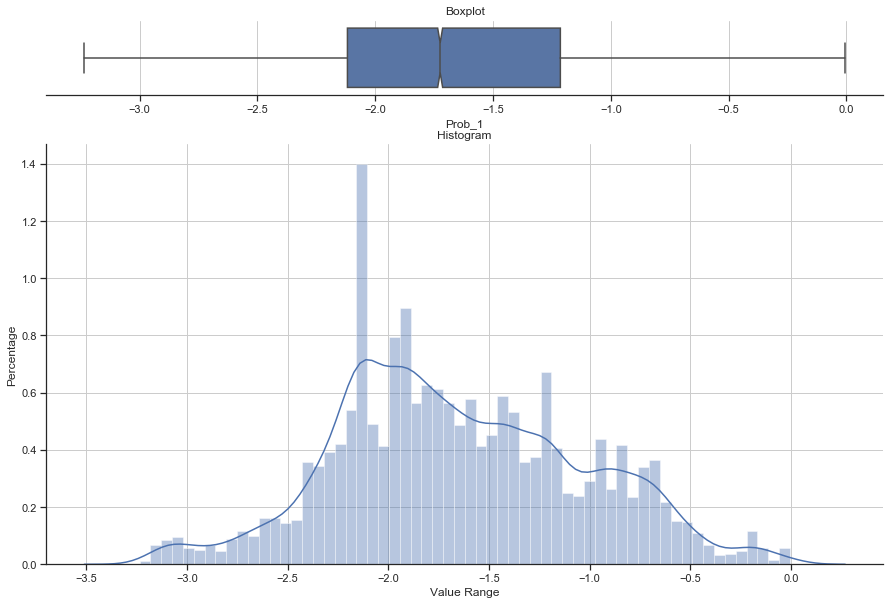

In [130]:
boxplot_histogram(np.log(scoring_all_prob.loc[:,"Prob_1"]),bins=60)

In [131]:
np.exp(-2.1)

0.1224564282529819

In [225]:
scoring_all_prob.loc[scoring_all_prob.loc[:,"Prob_1"]>0.166,:].shape[0]

9836

In [140]:
training_all.loc[:,["Target_Res_flg","Endkunde_NR"]].groupby("Target_Res_flg").count()

,Endkunde_NR
Target_Res_flg,
False,17312
True,691


In [141]:
691/17312


0.039914510166358594

# Appendix

## Mutual Information

In [108]:
%%time
mu_in = mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced)

Wall time: 18.8 s


In [109]:
print(mu_in.shape)
print(feature_columns.shape)

(100,)
(100,)


In [110]:
 mu_in_df = (pd.DataFrame({'Feature':            feature_columns,
                           'Mutual_Information': mu_in})
             .sort_values(by='Mutual_Information',
                          ascending=False)
             .reset_index(drop=True)
            )

In [111]:
display(mu_in_df.head(50))

,Feature,Mutual_Information
0,Erste_Letzte_Buchung_Delta,0.450051
1,Erste_Buchung_Delta,0.409881
2,Netto_Sum_Aus_RY_0_KW_1,0.386871
3,Netto_Sum_Res_RY_1_KW_39,0.369015
4,Netto_Sum_Aus_RY_0,0.318904
5,Netto_Sum_Res_RY_2_KW_39,0.311842
6,Netto_Sum_Res_RY_0,0.311650
7,Letzte_Buchung_Delta,0.299184
8,Netto_Sum_Res_RY_3_KW_39,0.279585
9,Netto_Sum_Aus_RY_3_KW_1,0.267900


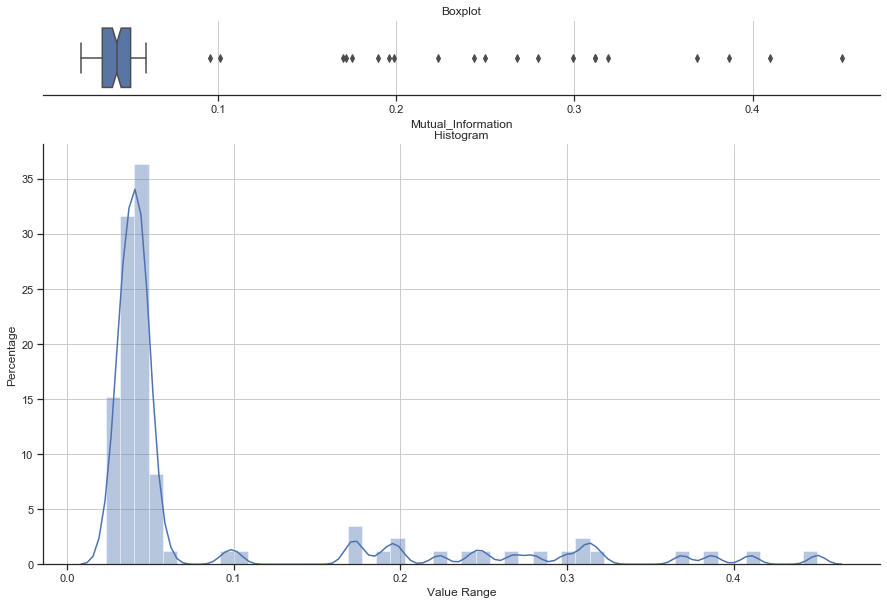

In [112]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [113]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [114]:
mu_in_cutoff(0.07)

,Feature,Mutual_Information
0,Erste_Letzte_Buchung_Delta,0.450051
1,Erste_Buchung_Delta,0.409881
2,Netto_Sum_Aus_RY_0_KW_1,0.386871
3,Netto_Sum_Res_RY_1_KW_39,0.369015
4,Netto_Sum_Aus_RY_0,0.318904
5,Netto_Sum_Res_RY_2_KW_39,0.311842
6,Netto_Sum_Res_RY_0,0.311650
7,Letzte_Buchung_Delta,0.299184
8,Netto_Sum_Res_RY_3_KW_39,0.279585
9,Netto_Sum_Aus_RY_3_KW_1,0.267900


In [116]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [117]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

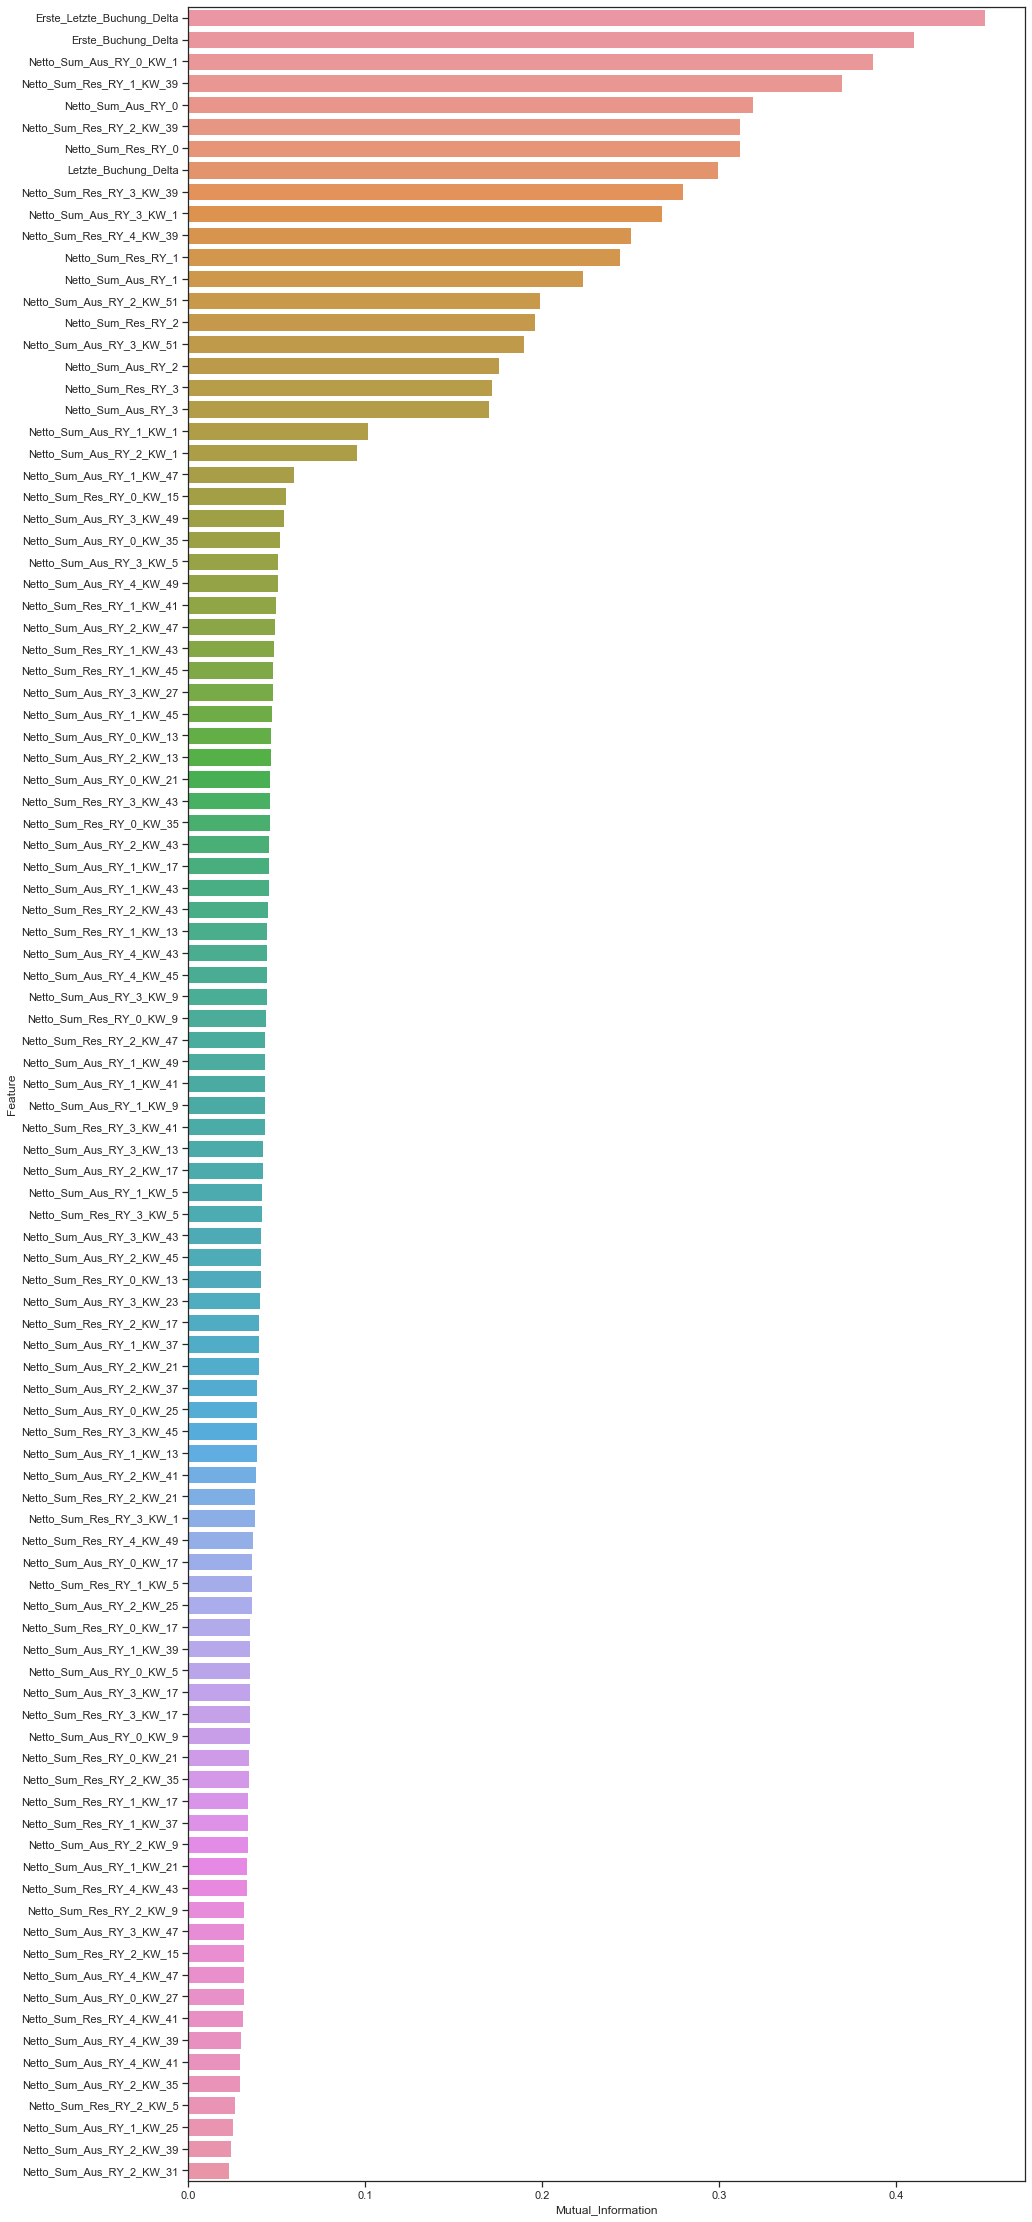

In [118]:
plt.figure(figsize=(15,40))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
